# word predictability beyond the solitary sentence

Here we evaluate whether predictions of word-level reading time can be improved by including longer spans of preceding text as context for the computation of surprisal. 

We follow previous [analyses](https://arxiv.org/pdf/2006.01912.pdf) on the [natural stories](https://github.com/languageMIT/naturalstories) corpus, and report changes in word-level log likelihood.

We show that models including more context show a delta-LL boost relative to models using just the sentence a word appears in that's comparable to the improvement one sees moving from an n-gram model to a Transformer-based LM. 

In other words, people's reading times integrate longer context windows, and our modeling of online sentence processing should reflect this fact!

In [1]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import torch
import numpy as np
import nltk.data
import pandas as pd
from nltk.tokenize import sent_tokenize

# boring pre-processing

In [2]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

In [8]:
# NATURAL STORIES
stories = pd.read_csv("./natural-stories/all_stories.tok", sep = "\t")
story_text = " ".join([x for x in stories["word"]])
sentences = sent_tokenize(story_text)

In [9]:
sent_idxs = []
word_idxs = []
current_sent_idx = 0
last_word_idx = 0

for word in stories["word"]:
    if last_word_idx == len(sentences[current_sent_idx]):
        current_sent_idx += 1
        last_word_idx = 0
    
    sent = sentences[current_sent_idx]
    start = sent.find(word, last_word_idx)
    end = start + len(word)
    last_word_idx = end
    sent_idxs.append(current_sent_idx)
    word_idxs.append((start, end))
    assert(word == sent[start:end])

stories['sentence_idx'] = sent_idxs
stories['word_spans'] = word_idxs

In [10]:
import string
exclude = set(string.punctuation)
stripped_words = []
stripped_spans = []

# iteratively remove punct from the start and end of the words, adjust span acccordingly
for word, span in zip(stories.word, stories.word_spans):
    start, end = span
    while (word[0] in exclude) or (word[-1] in exclude):
        if word[0] in exclude:
            word = word[1:]
            start += 1
        if word[-1] in exclude:
            word = word[:-1]
            end -= 1
    stripped_words.append(word)
    stripped_spans.append((start, end))

stories['stripped_spans'] = stripped_spans
stories['stripped_words'] = stripped_words

In [11]:
stories

,word,zone,item,sentence_idx,word_spans,stripped_spans,stripped_words
0,If,1,1,0,"(0, 2)","(0, 2)",If
1,you,2,1,0,"(3, 6)","(3, 6)",you
2,were,3,1,0,"(7, 11)","(7, 11)",were
3,to,4,1,0,"(12, 14)","(12, 14)",to
4,journey,5,1,0,"(15, 22)","(15, 22)",journey
...,...,...,...,...,...,...,...
10251,and,935,10,496,"(64, 67)","(64, 67)",and
10252,better,936,10,496,"(68, 74)","(68, 74)",better
10253,treatments,937,10,496,"(75, 85)","(75, 85)",treatments
10254,for,938,10,496,"(86, 89)","(86, 89)",for


In [12]:
sentence_spans = lambda sent_idx : list(stories[stories.sentence_idx == sent_idx].stripped_spans)
sentence_words = lambda sent_idx : list(stories[stories.sentence_idx == sent_idx].stripped_words)

In [13]:
word_surprisals = []
for sentence_idx, sentence in enumerate(sentences):
    sent_words = sentence_words(sentence_idx)
    inputs = tokenizer(sentence, return_tensors="pt")
    sent_tokens = inputs.tokens()
    indexed_tokens = inputs['input_ids']
    word_tokens = []
    for span in sentence_spans(sentence_idx):
        tokens = []
        start, end = span
        for char in range(start, end):
            tokens.append(inputs.char_to_token(char))
        word_tokens.append(list(set(tokens)))
        
    with torch.no_grad():
        logprobs = model(**inputs, labels=indexed_tokens).logits.log_softmax(dim=2).squeeze()

    logprobs = (None,) + logprobs.unbind()
    surprisals = []
    for i, token_idx in enumerate(indexed_tokens.squeeze()):
        if logprobs[i] == None: 
            surprisal = 0
        else:
            # find the log prob of the actual token in the vocab at the ith sentence position
            surprisal = -logprobs[i][token_idx].item() / torch.log(torch.tensor(2))
        surprisals.append(float(surprisal))
    
    for tokens in word_tokens:
        token_surprisals = [surprisals[token] for token in tokens]
        word_surprisal = sum(token_surprisals)
        word_surprisals.append(word_surprisal)

stories['surprisals'] = word_surprisals

In [21]:
story_idxs = list(stories.item.unique())
story_sentences = lambda story_idx : list(stories[stories.item==story_idx].sentence_idx.unique())

In [22]:
for n_back in range(1,11):
    n_back_surprisals = []
    for story in story_idxs:
        sentence_idxs = story_sentences(story)
        for i, sentence_idx in enumerate(sentence_idxs):
            # first sentence of the story skipped
            if i < n_back: n_back_surprisals += [None] * len(sentence_words(sentence_idx))
            else:
                current_sentence = sentences[sentence_idx]
                prev_sentences = [sentences[sentence_idx - n_sent_back] for n_sent_back in range(1, n_back+1)]
                combo_prev = ' '.join(prev_sentences)
                combo_sentence = ' '.join([combo_prev, current_sentence])
                offset = len(combo_prev) + 1

                inputs = tokenizer(combo_sentence, return_tensors="pt")
                sent_tokens = inputs.tokens()
                indexed_tokens = inputs['input_ids']
                word_tokens = []
                for span in sentence_spans(sentence_idx):
                    tokens = []
                    start, end = span
                    start += offset
                    end += offset
                    for char in range(start, end):
                        tokens.append(inputs.char_to_token(char))
                    word_tokens.append(list(set(tokens)))

                with torch.no_grad():
                    logprobs = model(**inputs, labels=indexed_tokens).logits.log_softmax(dim=2).squeeze()

                logprobs = (None,) + logprobs.unbind()
                surprisals = []
                for j, token_idx in enumerate(indexed_tokens.squeeze()):
                    if logprobs[j] == None: 
                        surprisal = 0
                    else:
                        # find the log prob of the actual token in the vocab at the ith sentence position
                        surprisal = -logprobs[j][token_idx].item() / torch.log(torch.tensor(2))
                    surprisals.append(float(surprisal))

                for tokens in word_tokens:
                    token_surprisals = [surprisals[token] for token in tokens]
                    word_surprisal = sum(token_surprisals)
                    n_back_surprisals.append(word_surprisal)

    stories['surprisals_%dback'%(n_back)] = n_back_surprisals

In [23]:
freqs = pd.read_csv('./natural-stories/freqs-3.tsv', sep='\t', names=['id', 'n', 'token', 'n-gram-freq', 'n-minus-gram-freq'])
id_splits = list(freqs.id.apply(lambda x: x.split('.')))

freqs['story_id'] = [int(split[0]) for split in id_splits]
freqs['word_id'] = [int(split[1]) for split in id_splits]
freqs['word_part'] = [split[2] for split in id_splits]
freqs['cond_prob'] = freqs['n-gram-freq'] / freqs['n-minus-gram-freq']
freqs['ngram_surprisal'] = -np.log2(freqs['cond_prob']+1)

In [24]:
def find_cond_prob(row):
    story_id = row['item']
    word_id = row['zone']
    cond_prob = None
    search = freqs[(freqs.story_id==story_id) & (freqs.word_id==word_id) & (freqs.word_part=='word')]
    if not search.empty:
        cond_prob = search.iloc[0]['cond_prob']
    return cond_prob

def find_ngram_surprisal(row):
    story_id = row['item']
    word_id = row['zone']
    cond_prob = None
    search = freqs[(freqs.story_id==story_id) & (freqs.word_id==word_id) & (freqs.word_part=='word')]
    if not search.empty:
        cond_prob = search.iloc[0]['ngram_surprisal']
    return cond_prob

stories['ngram_prob'] = stories.apply(find_cond_prob, axis=1)
stories['ngram_surprisal'] = stories.apply(find_ngram_surprisal, axis=1)

In [25]:
rts = pd.read_csv('./natural-stories/processed_RTs.tsv', sep='\t')

def find_rt(row):
    story_id = row['item']
    word_id = row['zone']

    cond_prob = None
    search = rts[(rts.item==story_id) & (rts.zone==word_id)]
    if not search.empty:
        mean_rt = search.iloc[0]['meanItemRT']
    return mean_rt

stories['mean_rt'] = stories.apply(find_rt, axis=1)

In [26]:
wilcox_results = pd.read_csv('./data/harmonized_results.csv')

def find_freq(row):
    wilcox_code = (row['item'] * 10000) + row['zone']
    print(wilcox_code)
    try:
        wilcox_row = wilcox_results[(wilcox_results.corpus == 'natural-stories') & (wilcox_results.code==wilcox_code)].iloc[0]
        assert(row['word'] == wilcox_row['word'])
        return wilcox_row['freq']
    except Exception as e:
        print(row['word'], wilcox_code, e)
        return None

stories['unigram_logprob'] = stories.apply(find_freq, axis=1)



10001
10002
10003
10004
10005
10006
10007
10008
10009
10010
England, 10010 single positional indexer is out-of-bounds
10011
10012
10013
10014
10015
10016
10017
10018
10019
10020
10021
10022
10023
10024
10025
mountains. 10025 single positional indexer is out-of-bounds
10026
10027
10028
10029
10030
10031
10032
10033
10034
10035
10036
10037
10038
Bradford, 10038 single positional indexer is out-of-bounds
10039
10040
10041
10042
10043
10044
10045
10046
10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10057
owners. 10057 single positional indexer is out-of-bounds
10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
Bradford, 10085 single positional indexer is out-of-bounds
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
Hall, 10100 single positional indexer is out-of-bounds
10101
10102
10103
10104
10105
10106
10107
10108
1010

10709
10710
10711
10712
rewarded, 10712 single positional indexer is out-of-bounds
10713
10714
10715
promised.' 10715 single positional indexer is out-of-bounds
10716
10717
first, 10717 single positional indexer is out-of-bounds
10718
10719
10720
10721
10722
10723
10724
10725
monster,' 10725 single positional indexer is out-of-bounds
10726
10727
10728
10729
10730
10731
Manor. 10731 single positional indexer is out-of-bounds
10732
10733
10734
10735
10736
10737
10738
10739
10740
10741
10742
10743
10744
10745
10746
10747
10748
10749
huntsman. 10749 single positional indexer is out-of-bounds
10750
10751
away, 10751 single positional indexer is out-of-bounds
10752
10753
10754
10755
10756
10757
10758
10759
10760
10761
10762
10763
exclaimed, 10763 single positional indexer is out-of-bounds
10764
10765
10766
this? 10766 single positional indexer is out-of-bounds
10767
10768
10769
10770
10771
tongue?' 10771 single positional indexer is out-of-bounds
10772
10773
10774
10775
10776
huntsman, 10776

20280
20281
20282
20283
20284
20285
20286
20287
20288
20289
20290
changed, 20290 single positional indexer is out-of-bounds
20291
20292
20293
20294
20295
20296
20297
20298
20299
20300
20301
20302
20303
20304
20305
20306
20307
20308
20309
carry. 20309 single positional indexer is out-of-bounds
20310
20311
20312
20313
20314
sailed, 20314 single positional indexer is out-of-bounds
20315
20316
20317
20318
20319
grand, 20319 single positional indexer is out-of-bounds
20320
20321
20322
20323
20324
20325
20326
20327
20328
20329
water, 20329 single positional indexer is out-of-bounds
20330
20331
20332
20333
20334
dizzy. 20334 single positional indexer is out-of-bounds
20335
20336
20337
20338
20339
20340
20341
20342
below, 20342 single positional indexer is out-of-bounds
20343
20344
20345
20346
20347
20348
20349
20350
20351
20352
20353
20354
earth, 20354 single positional indexer is out-of-bounds
20355
20356
20357
20358
20359
20360
20361
20362
20363
20364
20365
20366
20367
20368
20369
bed. 2036

20932
safest, 20932 single positional indexer is out-of-bounds
20933
20934
20935
20936
20937
20938
20939
world. 20939 single positional indexer is out-of-bounds
20940
20941
20942
20943
20944
evenings, 20944 single positional indexer is out-of-bounds
20945
20946
20947
20948
20949
20950
20951
20952
20953
beach, 20953 single positional indexer is out-of-bounds
20954
20955
20956
20957
20958
20959
20960
20961
20962
20963
20964
20965
20966
20967
20968
20969
20970
20971
20972
20973
20974
20975
20976
20977
20978
20979
20980
20981
20982
20983
20984
20985
20986
20987
20988
20989
20990
world. 20990 single positional indexer is out-of-bounds
30001
30002
30003
30004
30005
30006
30007
30008
30009
30010
30011
30012
30013
30014
year, 30014 single positional indexer is out-of-bounds
30015
30016
30017
30018
30019
30020
30021
30022
furious. 30022 single positional indexer is out-of-bounds
30023
30024
30025
30026
30027
30028
30029
30030
30031
30032
30033
30034
30035
30036
30037
30038
30039
30040
30041
300

30622
30623
30624
30625
30626
30627
underbrush. 30627 single positional indexer is out-of-bounds
30628
30629
30630
30631
curious, 30631 single positional indexer is out-of-bounds
30632
30633
30634
30635
30636
30637
30638
30639
30640
30641
30642
30643
was, 30643 single positional indexer is out-of-bounds
30644
30645
30646
30647
30648
30649
30650
30651
back. 30651 single positional indexer is out-of-bounds
30652
30653
30654
30655
30656
30657
30658
30659
30660
30661
place, 30661 single positional indexer is out-of-bounds
30662
30663
30664
30665
30666
30667
30668
30669
found. 30669 single positional indexer is out-of-bounds
30670
30671
30672
30673
30674
out, 30674 single positional indexer is out-of-bounds
30675
30676
30677
30678
30679
30680
30681
30682
30683
30684
eyes. 30684 single positional indexer is out-of-bounds
30685
30686
30687
30688
30689
thick, 30689 single positional indexer is out-of-bounds
30690
damp, 30690 single positional indexer is out-of-bounds
30691
30692
wall. 30692 si

40214
40215
40216
40217
40218
king. 40218 single positional indexer is out-of-bounds
40219
40220
40221
40222
40223
40224
40225
40226
40227
40228
first, 40228 single positional indexer is out-of-bounds
40229
40230
40231
40232
40233
40234
40235
40236
40237
40238
40239
40240
40241
40242
40243
40244
40245
40246
40247
40248
commence. 40248 single positional indexer is out-of-bounds
40249
40250
40251
40252
40253
40254
40255
40256
40257
40258
40259
40260
40261
40262
40263
40264
given. 40264 single positional indexer is out-of-bounds
40265
40266
40267
40268
40269
40270
dust, 40270 single positional indexer is out-of-bounds
40271
40272
40273
40274
40275
40276
40277
40278
40279
40280
40281
40282
40283
field. 40283 single positional indexer is out-of-bounds
40284
40285
40286
40287
40288
40289
40290
40291
40292
40293
40294
40295
40296
40297
away. 40297 single positional indexer is out-of-bounds
40298
40299
40300
40301
40302
40303
40304
40305
40306
40307
40308
40309
earth. 40309 single positional i

40862
40863
40864
40865
40866
40867
40868
other,' 40868 single positional indexer is out-of-bounds
40869
40870
thought. 40870 single positional indexer is out-of-bounds
40871
40872
40873
40874
40875
40876
40877
40878
40879
40880
40881
other, 40881 single positional indexer is out-of-bounds
40882
40883
40884
40885
40886
40887
40888
40889
40890
40891
40892
40893
open, 40893 single positional indexer is out-of-bounds
40894
40895
40896
40897
40898
40899
asleep. 40899 single positional indexer is out-of-bounds
40900
40901
40902
40903
40904
40905
40906
40907
40908
40909
out, 40909 single positional indexer is out-of-bounds
40910
40911
40912
40913
40914
40915
40916
40917
40918
40919
shut, 40919 single positional indexer is out-of-bounds
40920
40921
40922
40923
40924
40925
40926
40927
away. 40927 single positional indexer is out-of-bounds
40928
40929
40930
40931
shout, 40931 single positional indexer is out-of-bounds
40932
40933
40934
king' 40934 single positional indexer is out-of-bounds
4093

50440
50441
orphans. 50441 single positional indexer is out-of-bounds
50442
50443
50444
50445
50446
50447
50448
50449
50450
50451
50452
called, 50452 single positional indexer is out-of-bounds
50453
50454
50455
50456
50457
50458
50459
50460
50461
50462
50463
50464
50465
50466
50467
50468
50469
50470
50471
50472
50473
50474
50475
50476
50477
50478
50479
50480
higher. 50480 single positional indexer is out-of-bounds
50481
50482
50483
50484
50485
50486
50487
said, 50487 single positional indexer is out-of-bounds
50488
50489
50490
50491
50492
50493
50494
face, 50494 single positional indexer is out-of-bounds
50495
50496
50497
50498
50499
haircut. 50499 single positional indexer is out-of-bounds
50500
50501
50502
50503
50504
50505
50506
Elvis's?' 50506 
50507
50508
asked. 50508 single positional indexer is out-of-bounds
50509
50510
barber, 50510 single positional indexer is out-of-bounds
50511
50512
50513
50514
50515
50516
man, 50516 single positional indexer is out-of-bounds
50517
50518
50

60094
60095
60096
60097
60098
60099
60100
snail, 60100 single positional indexer is out-of-bounds
60101
60102
60103
60104
60105
him. 60105 single positional indexer is out-of-bounds
60106
60107
60108
60109
60110
60111
60112
60113
60114
60115
60116
60117
60118
60119
60120
60121
60122
60123
60124
bottom, 60124 single positional indexer is out-of-bounds
60125
60126
60127
60128
60129
gravel. 60129 single positional indexer is out-of-bounds
60130
60131
60132
60133
day, 60133 single positional indexer is out-of-bounds
60134
Abby, 60134 single positional indexer is out-of-bounds
60135
60136
60137
60138
teacher, 60138 single positional indexer is out-of-bounds
60139
60140
60141
60142
60143
60144
60145
60146
Mr. 60146 single positional indexer is out-of-bounds
60147
Sticky, 60147 single positional indexer is out-of-bounds
60148
60149
60150
60151
60152
60153
60154
60155
60156
gravel. 60156 single positional indexer is out-of-bounds
60157
60158
60159
60160
60161
60162
60163
her, 60163 single posi

60654
60655
60656
60657
60658
60659
60660
60661
see. 60661 single positional indexer is out-of-bounds
60662
'What's 60662 single positional indexer is out-of-bounds
60663
60664
60665
60666
small?' 60666 single positional indexer is out-of-bounds
60667
60668
60669
all, 60669 single positional indexer is out-of-bounds
60670
60671
60672
60673
60674
60675
60676
find.' 60676 single positional indexer is out-of-bounds
60677
60678
notice,' 60678 single positional indexer is out-of-bounds
60679
60680
said, 60680 single positional indexer is out-of-bounds
60681
60682
60683
60684
60685
small, 60685 single positional indexer is out-of-bounds
60686
60687
Mr. 60687 single positional indexer is out-of-bounds
60688
60689
60690
60691
60692
60693
60694
room. 60694 single positional indexer is out-of-bounds
60695
60696
60697
60698
60699
60700
60701
60702
60703
60704
60705
60706
60707
60708
appeared. 60708 single positional indexer is out-of-bounds
60709
60710
60711
60712
60713
60714
60715
60716
60717
60

70131
70132
70133
70134
70135
70136
70137
70138
70139
70140
dejectedly, 70140 single positional indexer is out-of-bounds
70141
'I'm 70141 single positional indexer is out-of-bounds
70142
70143
70144
70145
70146
was.' 70146 single positional indexer is out-of-bounds
70147
'Haven't 70147 single positional indexer is out-of-bounds
70148
70149
70150
70151
yet?' 70151 single positional indexer is out-of-bounds
70152
70153
Jill, 70153 single positional indexer is out-of-bounds
70154
70155
70156
70157
70158
70159
70160
70161
70162
70163
seat. 70163 single positional indexer is out-of-bounds
70164
'Yes,' 70164 single positional indexer is out-of-bounds
70165
70166
replied, 70166 single positional indexer is out-of-bounds
70167
70168
70169
70170
teeth. 70170 single positional indexer is out-of-bounds
70171
70172
70173
70174
70175
70176
70177
70178
70179
70180
70181
70182
70183
70184
70185
70186
70187
70188
70189
70190
70191
arguments, 70191 single positional indexer is out-of-bounds
70192
70193

70783
70784
out, 70784 single positional indexer is out-of-bounds
70785
70786
70787
audience, 70787 single positional indexer is out-of-bounds
70788
70789
70790
70791
70792
70793
70794
over, 70794 single positional indexer is out-of-bounds
70795
70796
70797
messages, 70797 single positional indexer is out-of-bounds
70798
70799
70800
70801
70802
70803
70804
feel. 70804 single positional indexer is out-of-bounds
70805
70806
70807
70808
70809
70810
70811
music, 70811 single positional indexer is out-of-bounds
70812
70813
70814
70815
70816
70817
70818
70819
70820
70821
70822
70823
70824
70825
life. 70825 single positional indexer is out-of-bounds
70826
70827
70828
70829
sing, 70829 single positional indexer is out-of-bounds
70830
70831
70832
70833
70834
70835
70836
70837
70838
70839
70840
70841
70842
70843
70844
70845
70846
out. 70846 single positional indexer is out-of-bounds
70847
70848
70849
70850
70851
important, 70851 single positional indexer is out-of-bounds
70852
70853
70854
70855


80424
80425
80426
80427
80428
poll, 80428 single positional indexer is out-of-bounds
80429
80430
80431
80432
80433
80434
80435
80436
80437
80438
80439
80440
80441
80442
80443
80444
80445
80446
80447
80448
80449
80450
fact. 80450 single positional indexer is out-of-bounds
80451
80452
80453
80454
80455
80456
80457
nineties, 80457 single positional indexer is out-of-bounds
80458
80459
80460
80461
80462
80463
80464
80465
80466
80467
80468
80469
80470
80471
80472
80473
forty-seven. 80473 single positional indexer is out-of-bounds
80474
80475
80476
80477
80478
80479
80480
80481
80482
80483
80484
80485
80486
80487
80488
80489
80490
80491
80492
eighty, 80492 single positional indexer is out-of-bounds
80493
80494
80495
80496
80497
80498
80499
emerged, 80499 single positional indexer is out-of-bounds
80500
80501
80502
80503
80504
80505
80506
80507
80508
80509
incident. 80509 single positional indexer is out-of-bounds
80510
80511
80512
80513
80514
80515
80516
80517
80518
80519
interviewed, 80519 

Turkey, 90158 single positional indexer is out-of-bounds
90159
90160
90161
90162
90163
90164
90165
90166
90167
90168
90169
90170
climate. 90170 single positional indexer is out-of-bounds
90171
90172
90173
90174
90175
90176
90177
90178
90179
90180
90181
90182
popularity. 90182 single positional indexer is out-of-bounds
90183
90184
90185
90186
90187
90188
90189
90190
90191
90192
90193
90194
symbol, 90194 single positional indexer is out-of-bounds
90195
90196
90197
90198
90199
90200
followed. 90200 single positional indexer is out-of-bounds
90201
90202
90203
90204
90205
groups: 90205 single positional indexer is out-of-bounds
90206
90207
90208
90209
red, 90209 single positional indexer is out-of-bounds
90210
yellow, 90210 single positional indexer is out-of-bounds
90211
90212
90213
90214
90215
90216
Couleren, 90216 single positional indexer is out-of-bounds
90217
90218
90219
90220
90221
90222
90223
(red 90223 single positional indexer is out-of-bounds
90224
90225
90226
90227
90228
backgro

90743
90744
90745
90746
90747
90748
90749
90750
90751
90752
90753
bulb. 90753 single positional indexer is out-of-bounds
90754
90755
90756
90757
90758
90759
90760
90761
90762
90763
90764
90765
90766
90767
desperate, 90767 single positional indexer is out-of-bounds
90768
90769
90770
90771
90772
90773
90774
shock. 90774 single positional indexer is out-of-bounds
90775
90776
90777
account, 90777 single positional indexer is out-of-bounds
90778
90779
90780
90781
90782
90783
90784
90785
90786
90787
90788
90789
Netherlands, 90789 single positional indexer is out-of-bounds
90790
90791
90792
90793
90794
90795
90796
90797
90798
90799
90800
90801
90802
90803
90804
90805
90806
90807
90808
90809
90810
90811
90812
90813
90814
90815
90816
fee. 90816 single positional indexer is out-of-bounds
90817
90818
90819
90820
90821
90822
90823
90824
90825
90826
90827
90828
90829
90830
90831
90832
unsuccessful. 90832 single positional indexer is out-of-bounds
90833
90834
90835
90836
ended, 90836 single position

100325
100326
sounds. 100326 single positional indexer is out-of-bounds
100327
100328
100329
100330
distinct, 100330 single positional indexer is out-of-bounds
100331
100332
100333
100334
100335
100336
100337
100338
100339
groups. 100339 single positional indexer is out-of-bounds
100340
100341
100342
100343
100344
100345
100346
100347
100348
100349
100350
100351
100352
100353
100354
100355
shrug. 100355 single positional indexer is out-of-bounds
100356
100357
100358
100359
100360
100361
100362
100363
purposeful, 100363 single positional indexer is out-of-bounds
100364
100365
100366
100367
100368
objects, 100368 single positional indexer is out-of-bounds
100369
hopping, 100369 single positional indexer is out-of-bounds
100370
jumping, 100370 single positional indexer is out-of-bounds
100371
bending, 100371 single positional indexer is out-of-bounds
100372
100373
twisting. 100373 single positional indexer is out-of-bounds
100374
100375
100376
100377
100378
100379
100380
phrases. 100380 s

and 100935 single positional indexer is out-of-bounds
100936
better 100936 single positional indexer is out-of-bounds
100937
treatments 100937 single positional indexer is out-of-bounds
100938
for 100938 single positional indexer is out-of-bounds
100939
Tourette's. 100939 single positional indexer is out-of-bounds


In [27]:
get_len = lambda row: len(row['stripped_words'])
stories['len'] = stories.apply(get_len, axis=1)

In [28]:
# for a given row, find the value of col_name for the word that's n items back
def find_prev(row, col_name, n_back):
    prev_row = stories[(stories.item==row['item']) & (stories.zone==row['zone']-n_back)]
    if prev_row.empty:
        return None
    else:
        return prev_row.iloc[0][col_name]
    

rep_cols = ['len', 'unigram_logprob', 'surprisals'] + ['surprisals_%dback'%(n_back) for n_back in range(1, 11)]
for i in range(1, 4):
    for col in rep_cols:
        stories[col+'_prev'+str(i)] = stories.apply(find_prev, col_name=col, n_back=i, axis=1)

# actual modeling

In [29]:
# reg_df = stories[(stories.surprisals != 0) & (stories.surprisals_oneback.notnull()) & (stories.surprisals_threeback.notnull()) & (stories.ngram_prob.notnull()) & (stories.surprisals_tenback.notnull()) & (stories.mean_rt.notnull())]
reg_df = stories[(stories.notnull().all(axis=1)) & (stories.surprisals != 0)]

In [32]:
reg_df['surprisal_diff'] = reg_df.surprisals_10back - reg_df.surprisals
reg_df.surprisal_diff.mean()

/var/folders/dm/33ny_1vs1wx0cs2ydxh_5x640000gn/T/ipykernel_48095/1277293519.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_df['surprisal_diff'] = reg_df.surprisals_10back - reg_df.surprisals


-0.8377651319637944

In [39]:
reg_df.to_pickle("./reg_df.pkl")  

In [40]:
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
# reg_df = pd.read_pickle("./dummy.pkl")  

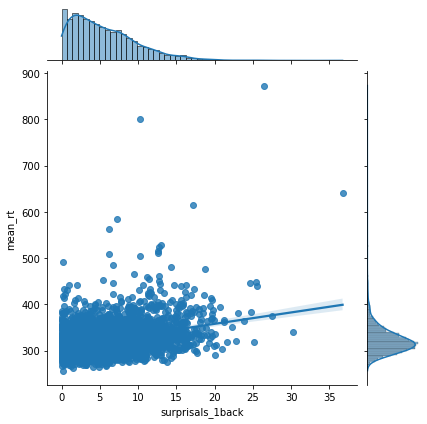

In [37]:
g = sns.jointplot(x="surprisals_1back", y="mean_rt", data=reg_df,
                  kind="reg")

In [41]:
# surprisals_oneback
#formula = 'mean_rt ~ len + ngram_prob'
formula = 'mean_rt ~ len + len_prev1 + len_prev2 + unigram_logprob + unigram_logprob_prev1 + unigram_logprob_prev2 + unigram_logprob_prev3'
mod0 = smf.glm(formula=formula, data=reg_df, family=sm.families.Gaussian(sm.genmod.families.links.Log())).fit()
print(mod0.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                mean_rt   No. Observations:                 4451
Model:                            GLM   Df Residuals:                     4443
Model Family:                Gaussian   Df Model:                            7
Link Function:                    Log   Scale:                          825.01
Method:                          IRLS   Log-Likelihood:                -21257.
Date:                Sat, 17 Sep 2022   Deviance:                   3.6655e+06
Time:                        13:35:52   Pearson chi2:                 3.67e+06
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1694
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 5.76

In [42]:
# surprisals
formula = 'mean_rt ~ surprisals + surprisals_prev1 + surprisals_prev2 + surprisals_prev3 + len + len_prev1 + len_prev2 + unigram_logprob + unigram_logprob_prev1 + unigram_logprob_prev2 + unigram_logprob_prev3'
mod1 = smf.glm(formula=formula, data=reg_df, family=sm.families.Gaussian(sm.genmod.families.links.Log())).fit()
print(mod1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                mean_rt   No. Observations:                 4451
Model:                            GLM   Df Residuals:                     4439
Model Family:                Gaussian   Df Model:                           11
Link Function:                    Log   Scale:                          782.07
Method:                          IRLS   Log-Likelihood:                -21136.
Date:                Sat, 17 Sep 2022   Deviance:                   3.4716e+06
Time:                        13:35:57   Pearson chi2:                 3.47e+06
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2224
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 5.67

In [45]:
# surprisals_oneback
formula = 'mean_rt ~ surprisals_1back + surprisals_1back_prev1 + surprisals_1back_prev1 + surprisals_1back_prev2 + surprisals_1back_prev3 + len + len_prev1 + len_prev2 + len_prev3 + unigram_logprob + unigram_logprob_prev1 + unigram_logprob_prev2 + unigram_logprob_prev3'
mod2 = smf.glm(formula=formula, data=reg_df, family=sm.families.Gaussian(sm.genmod.families.links.Log())).fit()
print(mod2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                mean_rt   No. Observations:                 4451
Model:                            GLM   Df Residuals:                     4438
Model Family:                Gaussian   Df Model:                           12
Link Function:                    Log   Scale:                          770.53
Method:                          IRLS   Log-Likelihood:                -21102.
Date:                Sat, 17 Sep 2022   Deviance:                   3.4196e+06
Time:                        13:37:19   Pearson chi2:                 3.42e+06
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2370
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5

In [46]:
# surprisals_threeback
formula = 'mean_rt ~ surprisals_3back + surprisals_3back_prev1 + surprisals_3back_prev2 + surprisals_3back_prev3 + len + len_prev1 + len_prev2 + len_prev3 + unigram_logprob + unigram_logprob_prev1 + unigram_logprob_prev2 + unigram_logprob_prev3'
mod3 = smf.glm(formula=formula, data=reg_df, family=sm.families.Gaussian(sm.genmod.families.links.Log())).fit()
print(mod3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                mean_rt   No. Observations:                 4451
Model:                            GLM   Df Residuals:                     4438
Model Family:                Gaussian   Df Model:                           12
Link Function:                    Log   Scale:                          761.13
Method:                          IRLS   Log-Likelihood:                -21075.
Date:                Sat, 17 Sep 2022   Deviance:                   3.3779e+06
Time:                        13:37:48   Pearson chi2:                 3.38e+06
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2488
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5

In [47]:
# surprisals_tenback
formula = 'mean_rt ~ surprisals_10back + surprisals_10back_prev1 + surprisals_10back_prev2 + surprisals_10back_prev3 + len + len_prev1 + len_prev2 + len_prev3 + unigram_logprob + unigram_logprob_prev1 + unigram_logprob_prev2 + unigram_logprob_prev3'
mod4 = smf.glm(formula=formula, data=reg_df, family=sm.families.Gaussian(sm.genmod.families.links.Log())).fit()
print(mod4.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                mean_rt   No. Observations:                 4451
Model:                            GLM   Df Residuals:                     4438
Model Family:                Gaussian   Df Model:                           12
Link Function:                    Log   Scale:                          759.96
Method:                          IRLS   Log-Likelihood:                -21072.
Date:                Sat, 17 Sep 2022   Deviance:                   3.3727e+06
Time:                        13:38:04   Pearson chi2:                 3.37e+06
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2503
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [52]:
print('delta LL per word, 0-sents-back ' + str((mod1.llf - mod0.llf) / mod0.nobs))
print('delta LL per word, 1-sents-back ' + str((mod2.llf - mod0.llf) / mod0.nobs))
print('delta LL per word, 3-sents-back ' + str((mod3.llf - mod0.llf) / mod0.nobs))
print('delta LL per word, 10-sents-back ' + str((mod4.llf - mod0.llf) / mod0.nobs))

delta LL per word, 0-sents-back 0.027178797755254353
delta LL per word, 1-sents-back 0.034720917333819594
delta LL per word, 3-sents-back 0.040861336458759945
delta LL per word, 10-sents-back 0.0416276693104124
